In [11]:
import pandas as pd

Link to original fruits and veg dataset: https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition

### Base VGG 16

In [12]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input,decode_predictions
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
import matplotlib.pyplot as plt
import os
import numpy as np

In [7]:
model = VGG16(weights='imagenet')
print(model.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

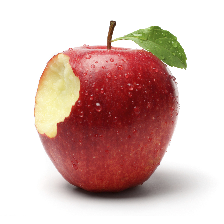

In [78]:
img_path = '/Users/lisadujesiefken/Documents/ULondon/Final Project/code/images/test/apple/Image_1.jpg'
img = image.load_img(img_path,color_mode='rgb', target_size=(224, 224))
display(img)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

In [79]:
predictions = model.predict(img_array)

# Decode and print the top-3 predicted classes
decoded_predictions = decode_predictions(predictions, top=3)[0]
print("Predictions:")
for i, (imagenet_id, label, score) in enumerate(decoded_predictions):
    print(f"{i + 1}: {label} ({score:.2f})")

1/1 [==============================] - 0s 142ms/step
Predictions:
1: Granny_Smith (0.58)
2: strawberry (0.23)
3: orange (0.07)


### Fine-tuning VGG 16 on dataset

In [8]:
# Load VGG16 model with pre-trained weights (excluding the top layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freezing pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

#number of classes in dataset
num_classes = 36
# Create a new model with custom top layers for your specific task
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))  # Change num_classes to the number of classes in your dataset

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [8]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 64
train_generator = train_datagen.flow_from_directory('/Users/lisadujesiefken/Documents/ULondon/Final Project/code/images/train',
                                                     target_size=(224, 224), batch_size=batch_size, class_mode='categorical')
validation_generator = test_datagen.flow_from_directory('/Users/lisadujesiefken/Documents/ULondon/Final Project/code/images/validation',
                                                         target_size=(224, 224), batch_size=batch_size, class_mode='categorical')


Found 3115 images belonging to 36 classes.
Found 351 images belonging to 36 classes.


In [11]:
#using 100 epochs
epochs = 100
history = model.fit(train_generator, epochs=epochs, validation_data=validation_generator)


Epoch 1/100
 3/49 [>.............................] - ETA: 4:39 - loss: 6.4740 - accuracy: 0.0208

/Users/lisadujesiefken/Documents/ULondon/Final Project/code/venv/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


49/49 [==============================] - 373s 8s/step - loss: 3.2130 - accuracy: 0.2600 - val_loss: 1.4144 - val_accuracy: 0.6724
Epoch 2/100
49/49 [==============================] - 360s 7s/step - loss: 1.6316 - accuracy: 0.5599 - val_loss: 0.7482 - val_accuracy: 0.8376
Epoch 3/100
49/49 [==============================] - 367s 7s/step - loss: 1.1277 - accuracy: 0.7034 - val_loss: 0.5755 - val_accuracy: 0.8575
Epoch 4/100
49/49 [==============================] - 378s 8s/step - loss: 0.8638 - accuracy: 0.7669 - val_loss: 0.4073 - val_accuracy: 0.9003
Epoch 5/100
49/49 [==============================] - 369s 8s/step - loss: 0.6645 - accuracy: 0.8225 - val_loss: 0.2769 - val_accuracy: 0.9487
Epoch 6/100
49/49 [==============================] - 357s 7s/step - loss: 0.5229 - accuracy: 0.8629 - val_loss: 0.2489 - val_accuracy: 0.9430
Epoch 7/100
49/49 [==============================] - 349s 7s/step - loss: 0.4107 - accuracy: 0.9018 - val_loss: 0.2277 - val_accuracy: 0.9402
Epoch 8/100
49/49 

### Assessing performance of fine-tuned VGG-16 model

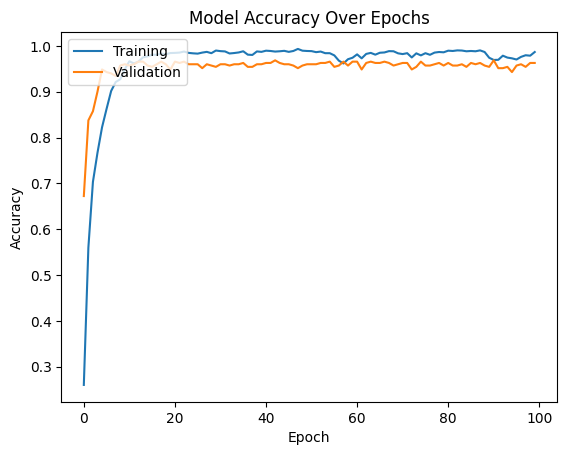

In [12]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

In [15]:
output_image_path = "VGG16_finetuned_100epochs_visualization.jpg"  # Change this to the desired output path
plt.savefig(output_image_path)

<Figure size 640x480 with 0 Axes>

In [10]:
#InceptionV3 accuracy and validation accuracy measures
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
print(f'VGG-16 Accuracy:{accuracy}')
print(f'VGG-16 Validation accuracy:{val_accuracy}')
print(f'VGG-16 Loss:{loss}')
print(f'VGG-16 Validation loss:{val_loss}')

NameError: name 'history' is not defined

In [16]:
metrics = {
    'Accuracy' : accuracy,
    'Validation accuracy' : val_accuracy,
    'Loss' : loss,
    'Validation loss': val_loss
}
df = pd.DataFrame(metrics)
df.to_csv('VGG16_finetuned_metric_df.csv')
df

,Accuracy,Validation accuracy,Loss,Validation loss
0,0.260032,0.672365,3.212986,1.414410
1,0.559872,0.837607,1.631629,0.748228
2,0.703371,0.857550,1.127658,0.575521
3,0.766934,0.900285,0.863759,0.407330
4,0.822472,0.948718,0.664505,0.276936
...,...,...,...,...
95,0.970465,0.957265,0.096051,0.320622
96,0.976244,0.960114,0.071887,0.279242
97,0.979775,0.954416,0.065028,0.291175
98,0.978812,0.962963,0.062827,0.215620


In [17]:
df.tail()

,Accuracy,Validation accuracy,Loss,Validation loss
95,0.970465,0.957265,0.096051,0.320622
96,0.976244,0.960114,0.071887,0.279242
97,0.979775,0.954416,0.065028,0.291175
98,0.978812,0.962963,0.062827,0.215620
99,0.986838,0.962963,0.034888,0.322599


In [14]:
model.save('vgg16_fine_tuned_epoch_100.h5')

/Users/lisadujesiefken/Documents/ULondon/Final Project/code/venv/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Testing fine-tuned VGG16 model

In [88]:
model = load_model('vgg16_fine_tuned.h5')

In [89]:
img_path = '/Users/lisadujesiefken/Documents/ULondon/Final Project/code/images/test/apple/Image_1.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)


In [90]:
predictions = model.predict(img_array)

# Assuming your model has been trained for classification
predicted_class = np.argmax(predictions)

print(f"Predicted Class: {predicted_class}")


1/1 [==============================] - 0s 124ms/step
Predicted Class: 0


In [91]:
class_labels = os.listdir('/Users/lisadujesiefken/Documents/ULondon/Final Project/code/images/test') 
predicted_class_label = class_labels[predicted_class]

print(f"Predicted Class Label: {predicted_class_label}")

Predicted Class Label: apple


### Base Inception V3 model

In [30]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
from tensorflow.keras.applications import InceptionV3

In [31]:
# Load and preprocess the image
img_path = '/Users/lisadujesiefken/Documents/ULondon/Final Project/code/images/test/apple/Image_1.jpg'
img = image.load_img(img_path, target_size=(299, 299))  
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

In [61]:
# Load InceptionV3 model with pre-trained weights
model = InceptionV3(weights='imagenet')


In [33]:
# Get predictions for the image
predictions = model.predict(img_array)

# Decode and print the top-3 predicted classes
decoded_predictions = decode_predictions(predictions, top=3)[0]
print("Predictions:")
for i, (imagenet_id, label, score) in enumerate(decoded_predictions):
    print(f"{i + 1}: {label} ({score:.2f})")


1/1 [==============================] - 0s 449ms/step
Predictions:
1: Granny_Smith (0.96)
2: pomegranate (0.00)
3: fig (0.00)


### Fine-tuning Inception model on Dataset

In [92]:
# Load InceptionV3 model with pre-trained weights (excluding the top layers)
base_model = InceptionV3(weights='imagenet', include_top=False)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for your specific task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)  # Change num_classes to the number of classes in your dataset

# Create a new model with custom top layers
model = Model(inputs=base_model.input, outputs=predictions)

In [93]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [94]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('/Users/lisadujesiefken/Documents/ULondon/Final Project/code/images/train',
                                                     target_size=(299, 299), batch_size=batch_size, class_mode='categorical')
validation_generator = test_datagen.flow_from_directory('/Users/lisadujesiefken/Documents/ULondon/Final Project/code/images/validation',
                                                         target_size=(299, 299), batch_size=batch_size, class_mode='categorical')

Found 3115 images belonging to 36 classes.
Found 351 images belonging to 36 classes.


In [95]:
#train model using same number of epoch as VGG16
history = model.fit(train_generator, epochs=25, validation_data=validation_generator)

Epoch 1/25


2024-01-05 13:57:46.617631: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


49/49 [==============================] - ETA: 0s - loss: 1.7185 - accuracy: 0.5400

2024-01-05 13:59:32.254240: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


49/49 [==============================] - 117s 2s/step - loss: 1.7185 - accuracy: 0.5400 - val_loss: 0.6052 - val_accuracy: 0.8291
Epoch 2/25
49/49 [==============================] - 116s 2s/step - loss: 0.7124 - accuracy: 0.7708 - val_loss: 0.4223 - val_accuracy: 0.8661
Epoch 3/25
49/49 [==============================] - 116s 2s/step - loss: 0.5514 - accuracy: 0.8263 - val_loss: 0.3300 - val_accuracy: 0.9231
Epoch 4/25
49/49 [==============================] - 114s 2s/step - loss: 0.4307 - accuracy: 0.8616 - val_loss: 0.3026 - val_accuracy: 0.9060
Epoch 5/25
49/49 [==============================] - 113s 2s/step - loss: 0.4042 - accuracy: 0.8658 - val_loss: 0.2984 - val_accuracy: 0.9145
Epoch 6/25
49/49 [==============================] - 113s 2s/step - loss: 0.3751 - accuracy: 0.8693 - val_loss: 0.2567 - val_accuracy: 0.9145
Epoch 7/25
49/49 [==============================] - 114s 2s/step - loss: 0.3144 - accuracy: 0.8928 - val_loss: 0.2312 - val_accuracy: 0.9316
Epoch 8/25
49/49 [======

In [96]:
model.save('inception_fine_tuned.h5')

### Assessing performance of fine-tuned Inception V3 model

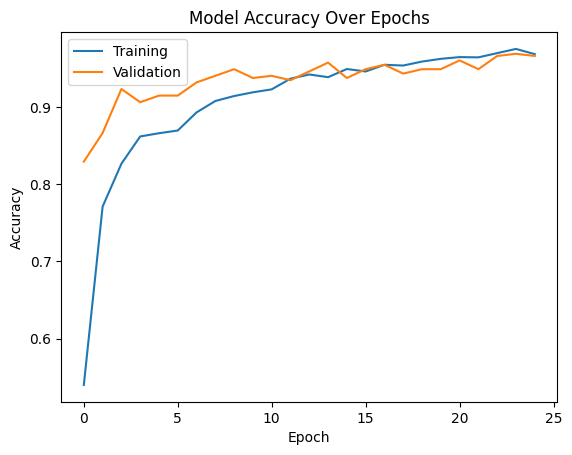

In [97]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

In [98]:
#InceptionV3 accuracy and validation accuracy measures
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
print(f'Inception V3 Accuracy:{accuracy}')
print(f'Inception V3 Validation accuracy:{val_accuracy}')
print(f'Inception V3 Loss:{loss}')
print(f'Inception V3 Validation loss:{val_loss}')

Inception V3 Accuracy:[0.5399678945541382, 0.7707865238189697, 0.8263242244720459, 0.8616372346878052, 0.8658105731010437, 0.8693419098854065, 0.8927769064903259, 0.9075441360473633, 0.9139646887779236, 0.9187800884246826, 0.9226323962211609, 0.9364365935325623, 0.9418940544128418, 0.9383627772331238, 0.9489566683769226, 0.9457463622093201, 0.9544141292572021, 0.9534510374069214, 0.9585874676704407, 0.9621188044548035, 0.9643659591674805, 0.9640449285507202, 0.9695023894309998, 0.9749598503112793, 0.9682183265686035]
Inception V3 Validation accuracy:[0.8290598392486572, 0.8660968542098999, 0.9230769276618958, 0.9059829115867615, 0.9145299196243286, 0.9145299196243286, 0.9316239356994629, 0.94017094373703, 0.9487179517745972, 0.9373219609260559, 0.94017094373703, 0.934472918510437, 0.945868968963623, 0.9572649598121643, 0.9373219609260559, 0.9487179517745972, 0.9544159770011902, 0.9430199265480042, 0.9487179517745972, 0.9487179517745972, 0.9601139426231384, 0.9487179517745972, 0.9658119

In [99]:
model = load_model('inception_fine_tuned.h5')

In [100]:
img_path = '/Users/lisadujesiefken/Documents/ULondon/Final Project/code/images/test/apple/Image_1.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

In [101]:
predictions = model.predict(img_array)

# Assuming your model has been trained for classification
predicted_class = np.argmax(predictions)

print(f"Predicted Class: {predicted_class}")

1/1 [==============================] - 1s 631ms/step
Predicted Class: 22


In [102]:
class_labels = os.listdir('/Users/lisadujesiefken/Documents/ULondon/Final Project/code/images/test')
predicted_class_label = class_labels[predicted_class]

print(f"Predicted Class Label: {predicted_class_label}")

Predicted Class Label: mango


### ResNet50 base evaluation

In [103]:
from tensorflow.keras.applications import ResNet50

In [50]:
# Load and preprocess the image
img_path = '/Users/lisadujesiefken/Documents/ULondon/Final Project/code/images/test/apple/Image_1.jpg'
img = image.load_img(img_path, target_size=(224, 224))  # ResNet50 requires input size (224, 224)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

In [51]:
# Load ResNet50 model with pre-trained weights
model = ResNet50(weights='imagenet')

102967424/102967424 [==============================] - 8s 0us/step


In [52]:
# Get predictions for the image
predictions = model.predict(img_array)

# Decode and print the top-3 predicted classes
decoded_predictions = decode_predictions(predictions, top=3)[0]
print("Predictions:")
for i, (imagenet_id, label, score) in enumerate(decoded_predictions):
    print(f"{i + 1}: {label} ({score:.2f})")


1/1 [==============================] - 0s 375ms/step
Predictions:
1: strawberry (0.35)
2: Granny_Smith (0.30)
3: pomegranate (0.08)


### Fine-tune ResNet50 model

In [104]:
# Load ResNet50 model with pre-trained weights (excluding the top layers)
base_model = ResNet50(weights='imagenet', include_top=False)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for your specific task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)  # Change num_classes to the number of classes in your dataset

# Create a new model with custom top layers
model = Model(inputs=base_model.input, outputs=predictions)

In [105]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [106]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('/Users/lisadujesiefken/Documents/ULondon/Final Project/code/images/train',
                                                     target_size=(299, 299), batch_size=batch_size, class_mode='categorical')
validation_generator = test_datagen.flow_from_directory('/Users/lisadujesiefken/Documents/ULondon/Final Project/code/images/validation',
                                                         target_size=(299, 299), batch_size=batch_size, class_mode='categorical')

Found 3115 images belonging to 36 classes.
Found 351 images belonging to 36 classes.


In [107]:
#using same epochs as other model
epochs = 25
history = model.fit(train_generator, epochs=25, validation_data=validation_generator)
model.save('resnet50_fine_tuned.h5')

Epoch 1/25


2024-01-05 14:47:41.481756: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


49/49 [==============================] - ETA: 0s - loss: 3.6709 - accuracy: 0.0350

2024-01-05 14:49:34.755258: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


49/49 [==============================] - 126s 3s/step - loss: 3.6709 - accuracy: 0.0350 - val_loss: 3.5853 - val_accuracy: 0.0256
Epoch 2/25
49/49 [==============================] - 124s 3s/step - loss: 3.5764 - accuracy: 0.0459 - val_loss: 3.5456 - val_accuracy: 0.0541
Epoch 3/25
49/49 [==============================] - 123s 2s/step - loss: 3.5463 - accuracy: 0.0507 - val_loss: 3.4932 - val_accuracy: 0.0484
Epoch 4/25
49/49 [==============================] - 124s 3s/step - loss: 3.5115 - accuracy: 0.0584 - val_loss: 3.4337 - val_accuracy: 0.0627
Epoch 5/25
49/49 [==============================] - 121s 2s/step - loss: 3.4744 - accuracy: 0.0636 - val_loss: 3.4039 - val_accuracy: 0.0655
Epoch 6/25
49/49 [==============================] - 127s 3s/step - loss: 3.4517 - accuracy: 0.0652 - val_loss: 3.4553 - val_accuracy: 0.0513
Epoch 7/25
49/49 [==============================] - 128s 3s/step - loss: 3.4303 - accuracy: 0.0758 - val_loss: 3.3632 - val_accuracy: 0.0598
Epoch 8/25
49/49 [======

### Assessing performance of fine-tuned ResNet50 model

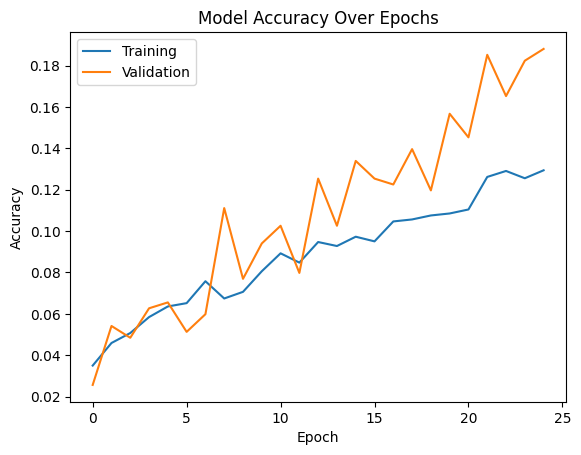

In [108]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

In [109]:
#ResNet50 accuracy and validation accuracy measures
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
print(f'ResNet50 Accuracy:{accuracy}')
print(f'ResNet50 Validation accuracy:{val_accuracy}')
print(f'ResNet50 Loss:{loss}')
print(f'ResNet50 Validation loss:{val_loss}')

ResNet50 Accuracy:[0.034991975873708725, 0.045906901359558105, 0.050722312182188034, 0.05842696502804756, 0.06356340646743774, 0.06516853719949722, 0.07576244324445724, 0.06741572916507721, 0.07062600553035736, 0.08057785034179688, 0.08924558758735657, 0.0847512036561966, 0.09470304846763611, 0.09277688711881638, 0.09727127104997635, 0.09502407908439636, 0.10465489327907562, 0.10561797767877579, 0.10754413902759552, 0.10850722342729568, 0.11043338477611542, 0.12616372108459473, 0.12905296683311462, 0.1255216747522354, 0.12937399744987488]
ResNet50 Validation accuracy:[0.025641025975346565, 0.054131053388118744, 0.04843304678797722, 0.06267806142568588, 0.0655270665884018, 0.05128205195069313, 0.05982905998826027, 0.1111111119389534, 0.07692307978868484, 0.09401709586381912, 0.10256410390138626, 0.07977207750082016, 0.12535612285137177, 0.10256410390138626, 0.1339031308889389, 0.12535612285137177, 0.12250712513923645, 0.13960114121437073, 0.11965811997652054, 0.156695157289505, 0.145299

In [110]:
model = load_model('resnet50_fine_tuned.h5')

In [111]:
img_path = '/Users/lisadujesiefken/Documents/ULondon/Final Project/code/images/test/apple/Image_1.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

In [112]:
predictions = model.predict(img_array)

# Assuming your model has been trained for classification
predicted_class = np.argmax(predictions)

print(f"Predicted Class: {predicted_class}")

class_labels = os.listdir('/Users/lisadujesiefken/Documents/ULondon/Final Project/code/images/test')  # Replace with your actual class labels
predicted_class_label = class_labels[predicted_class]

print(f"Predicted Class Label: {predicted_class_label}")

1/1 [==============================] - 0s 364ms/step
Predicted Class: 35
Predicted Class Label: carrot
